Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

План работы:  
<a href="#1.-Подготовка">1. Загрузим и подготовим данные</a>  
<a href="#2.-Обучение">2. Обучим разные модели</a>  
<a href="#3.-Выводы">3. Проанализируем результаты и сделаем выводы</a>

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import torch
import transformers
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm import notebook, tqdm, tqdm_notebook
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

In [2]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [3]:
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return ' '.join(text.split())

def lemmatize(text):
    m = Mystem()
    s = "".join(m.lemmatize(text))
    return s

In [5]:
comments.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

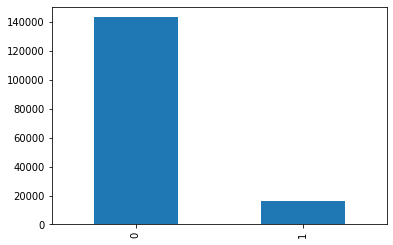

In [6]:
comments.toxic.value_counts().plot(kind='bar')

In [7]:
comments['clear_text'] = comments.text.apply(clear_text)

In [8]:
comments.head()

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


In [9]:
wnl = WordNetLemmatizer()

In [10]:
def wnl_lemmatize(text):
    s = []
    for word in text.split():
        s.append(wnl.lemmatize(word))
        #s.join(wnl.lemmatize(word))
    return ' '.join(s)

In [11]:
notebook.tqdm.pandas()
comments['lemm_text'] = comments['clear_text'].progress_apply(wnl_lemmatize)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [12]:
comments.head()

,text,toxic,clear_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir are my hero Any chance you remember wh...


In [13]:
comments = comments.drop('clear_text', axis=1)

In [14]:
comments.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


# 2. Обучение

In [15]:
# Разделим данные на обучающую и тестовую выборки
X = comments.drop(columns=['toxic'])
y = comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=666)

In [16]:
model = LogisticRegression(C=100, class_weight='balanced', dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=666, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)

In [17]:
# Создадим корпус на основе лемматизированного текста из обучающей выборки
corpus = X_train['lemm_text'].values.astype('U')

In [18]:
test_lemms = pd.concat([X_test, y_test], axis=1)

In [19]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stopwords = set(stopwords.words('english'))

In [21]:
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords)
tf_idf = tf_idf_vectorizer.fit_transform(corpus)
tf_idf.shape

(127656, 144393)

In [22]:
tf_idf_vectorizer.transform(test_lemms)

<3x144393 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [23]:
model.fit(tf_idf, y_train)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=666, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
test_tf_idf = tf_idf_vectorizer.transform(test_lemms['lemm_text'].values.astype('U'))

y_predicted = model.predict(test_tf_idf)

In [26]:
f1_score(y_test, y_predicted)

0.7512945702026927

# 3. Выводы

В методе очистки и лемматизации текстов я убрал приведение текста к нижнему регистру, т.к. вспомнил, что в интернете использование капслока интерпретируется как повышение голоса.

Предсказание Логистической регрессии дало значение метрики F1 0.7513. Задача выполнена :)

Параметры для модели я подбирал с помощью гридсёрча локально, т.к. при работе на хабе ядро часто падало. При попытке использовать CatBoost оперативная память тоже съедалась за несколько секунд и выполнить какие-либо расчеты не получалось.